# Paper Analysis

Going through multiple steps for the paper results


In this notebook so far: 

**Section 1: Data collection**
- 1.0: Pulling runs
- 1.1: Collecting into a table
- 1.2: Collecting CFHT data into table
- 1.3: Collecting GFS data
- 1.4: Collecting MASS DIMM data

**Section 2: Corellation Analysis**
- 2.1: Extracting Veloicities

**TODO:**
- 2.0? details on what is correlated?
- 2.1 clean up velocity extraction
- part 2.2 stats on how many layers seen in what percentage of data
- part 3 compare to wind data
- part 5 compare to injected layers

In [21]:
#imports
import numpy as np
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import os
import pytz
import datetime
from datetime import datetime as dt, timedelta
from astropy.time import Time
from datetime import datetime, date, timezone
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
import time
from importlib import reload

#personal
from pipeline.est_pipeline import *
from pipeline.code.Correlator import *
from pipeline.code.file_reader import *
from pipeline.code.corr_plots import *
from pipeline.code.cluster import *
from pipeline.code.data_table import *

import pipeline.code.Estimator as es
import pipeline.code.Estimator_R as er
import pipeline.code.graph_code as gc

# what we need as inputs:
date = "20200121"
fits_out_p = "/home/emcewen/out/"+date+"/"
fits_in_p = "/home/imaka/data/"+date+"/ao/"

run_input = "/home/emcewen/imaka_wfp/inputs/runs/"
out_dir = "/home/emcewen/out/"
wind_CFHT_p = "/home/emcewen/data/wind_cfht/"
wind_250_p = "/home/emcewen/data/wind_250mb/"
soundings_p = "/home/emcewen/data/mass_dimm_table.csv"

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Section 1: Data collection

## Part 0: what runs are used?

Listing out the runs and data tables. The function used to run any given runs are:
    `python3 pipeline/wfp_pipeline.py inputs/conf/CONF_data.txt inputs/runs/RUN14.txt`
    
    
Check in wfp_pipeline or cor_pipeline to check if the default tmax is still 1000 like it was during this runthrough

In [8]:
run_p = f'{run_input}RUN_paper.txt'

f = open(run_p, 'r')
print(f.read())

FLD2
20180531
20180601
20210429
20210430
20210501
20210502
Orion2
20181219
20181221
20181222
20181223


In [ ]:
# TODO: Excluding certain files

## Part 1: Collecting into a table 

In [12]:
##### MAIN CSV FUNCTION!!! 
##### THIS TAKES LIKE 5 MINUTES DON'T USE LIGHTLY

# generate a list of all the .txt files in run directory
run_files = [run_p]

#generates the DF!!! send in all the run files you'd like to use
df_main = df_gen_main(run_files, run_input, out_dir)

df_main.to_csv("csv/main_paper.csv")

## Part 2: Pulling CFHT data, add to table

To pull CFHT data: `wget http://mkwc.ifa.hawaii.edu/archive/wx/cfht/cfht-wx.2021.dat`

This should be in `emcewen/data/wind_cfht/`

### 2.1 Generating CFHT yearly files

We need to copy to move this into the actual data folder for cfht

In [4]:
#going through all CFHT files relevant to paper, converting each year to its own convenient csv

CFHT_NAMES = ['year', 'month', 'day', 'hour', 'minute', 'wind_speed(kts)', 
              'wind_direction(dec)', 'temperature(C)', 'relative_humidity(%)', 'pressure(mb-if present)']

years = ['2021']

for year in years:
    wind_CFHT = wind_CFHT_p + "cfht-wx.{}.dat".format(year)
    df = pd.read_csv(wind_CFHT, sep = ' ', names = CFHT_NAMES, index_col=False)
    
    df["pre_datetime"] = df['year'].astype(str) +'/'+ df['month'].astype(str) +'/'+ df['day'].astype(str) +" "+ df['hour'].apply('{0:0>2}'.format).astype(str)+':'+ df['minute'].apply('{0:0>2}'.format).astype(str)
    df["datetime"] = pd.to_datetime(df["pre_datetime"])
    df["datetime"] = df["datetime"].apply(hst_to_utc)
    
    df.drop(['year', 'month', 'day', 'hour', 'minute','pre_datetime'], axis=1, inplace=True)
    df.to_csv(wind_CFHT.replace(".dat", '.csv').replace(wind_CFHT_p, "csv/cfht/"), index=False)

### 2.2 Merging CFHT files with main.csv

In [6]:
##################### THIS GENERATES MAIN_cfht
#################### Expect it to take up to half an hour
# Now running a loop on all date-time data 

# pull main data
df_main = pd.read_csv("csv/main_paper.csv")
df_main["DATETIME"] = pd.to_datetime(df_main["DATETIME"])

#### WARNING: This function takes a lot of time ######
df_cfht = data_wind_cfht(df_main['DATETIME'].to_list(), wind_CFHT_p)

# for each date, get two values back
df_main_CFHT = pd.concat([df_main, df_cfht], axis=1, join="inner")

#print(df_main[['dataname', 'DATETIME','cfht_dt', "cft_wdir"]])
#store genereated csv file
df_main_CFHT.to_csv("csv/main_paper_cfht.csv", index=False)

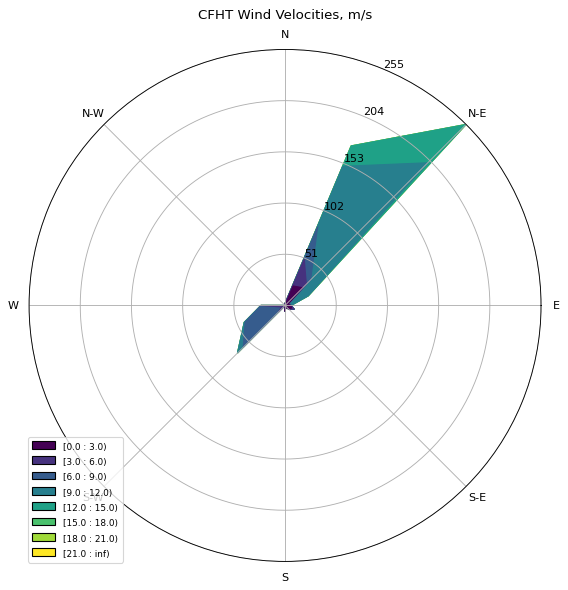

In [19]:
# Windplot for CFHT data

df_main = pd.read_csv("csv/main_paper_cfht.csv")
#df_main["DATETIME"] = pd.to_datetime(df_main["DATETIME"])
df_main = df_main[['cft_avg_wspd', 'cft_avg_wdir', "dataname"]].drop_duplicates()
df_main["cft_avg_wspd"] = df_main["cft_avg_wspd"] * 0.5144447
ws = df_main["cft_avg_wspd"].tolist()
wd = df_main["cft_avg_wdir"].tolist()

ax = WindroseAxes.from_ax()
ax.contourf(wd, ws, bins=np.arange(0, 24, 3), cmap=cm.viridis)
ax.set_legend()
ax.set_title("CFHT Wind Velocities, m/s")
plt.savefig('windplot_main_cfht_1.png')

## Part 3: Pulling mb data from GFS, add to table

Adding the predictions from the GFS models. 

Pull using a RUN_##.txt file and ```gfs_get.get``` code before using this notebooks following cells:

``` python3 gfs_get.py wfp/inputs/runs/RUN14.txt /home/emcewen/data/wind_250mb/```


### 3.1 Pulling together all GFS files

In [4]:
############# Generating list of GFS csvs ############
#for all files in wind_250_p 
files = os.listdir(wind_250_p)
#wind speeds
spd_files = [wind_250_p + fn for fn in files if fnmatch.fnmatch(fn, 'gfs.*.wspd.txt')]
#wind directions
dir_files = [wind_250_p + fn for fn in files if fnmatch.fnmatch(fn, 'gfs.*.wdir.txt')]


In [6]:
################# Generating GFS wind file ################
#creating pandas structure
#NAMES_250 = ['250_datetime', '250_wspd', '250_wdir']
df_250 = pd.DataFrame()

#for every file, pull the two corresponding dates
for i in range(len(spd_files)):
    spd_file = spd_files[i]
    datehour = spd_file.replace(wind_250_p, "").replace("gfs.", "").replace(".wspd.txt","")
    dir_file = wind_250_p+"gfs.{}.wdir.txt".format(datehour)
    df_d = pd.read_fwf(dir_file, memory_map=True, index_col=False)
    df_s = pd.read_fwf(spd_file, memory_map=True, index_col=False)
    di = 0
    si = 0
    dh  = datetime.strptime(str(datehour), "%Y%m%d%H")
    if math.isnan(df_d.iloc[di]["250"]) or math.isnan(df_s.iloc[si]["250"]): 
        di = 1
        si = 1
        dh = dh + timedelta(hours=1)
    dt_dic = {'datetime_gfs': dh,
                  '250_wspd': df_s.iloc[si]["250"], '250_wdir': df_d.iloc[di]["250"],
              '200_wspd': df_s.iloc[si]["200"], '200_wdir': df_d.iloc[di]["200"],
              '150_wspd': df_s.iloc[si]["150"], '150_wdir': df_d.iloc[di]["150"],
              '100_wspd': df_s.iloc[si]["100"], '100_wdir': df_d.iloc[di]["100"],
              '600_wspd': df_s.iloc[si]["600"], '600_wdir': df_d.iloc[di]["600"],
              '550_wspd': df_s.iloc[si]["550"], '550_wdir': df_d.iloc[di]["550"],
              '500_wspd': df_s.iloc[si]["500"], '500_wdir': df_d.iloc[di]["500"],
              '450_wspd': df_s.iloc[si]["450"], '450_wdir': df_d.iloc[di]["450"],
              '400_wspd': df_s.iloc[si]["400"], '400_wdir': df_d.iloc[di]["400"],
              '350_wspd': df_s.iloc[si]["350"], '350_wdir': df_d.iloc[di]["350"],
              '300_wspd': df_s.iloc[si]["300"], '300_wdir': df_d.iloc[di]["300"]
        }
    df_250 = df_250.append(dt_dic, ignore_index=True)
#df_250["250_datetime"] = pd.to_datetime(df_250["250_datetime"], format ="%Y%m%d%H")
df_250.to_csv("csv/wind_GFS_paper.csv", index=False)

### 3.2 Add to Main File

In [7]:
################# Combine with main file ################
# connect generate 250 data with current main table
def data_wind_250(datetimes, wind250_cvs):
    df_250 = pd.DataFrame()
    # open csv file
    df = pd.read_csv(wind250_cvs)
    df.index = pd.to_datetime(df['datetime_gfs'])
    df = df.groupby(level=0).first()
    for dt in datetimes:
        #getting the specific row
        spot = df.index.get_loc(dt, method='nearest')
        df_250 = df_250.append(df.iloc[spot], ignore_index=True)
        #print(df_250)
    return df_250

In [8]:
# Now running a loop on all date-time data 
# pull main data
df_main = pd.read_csv("csv/main_paper.csv", index_col=0)
df_main["DATETIME"] = pd.to_datetime(df_main["DATETIME"])

## creating df to pull in data from 
df_250 = data_wind_250(df_main['DATETIME'].to_list(), "csv/wind_GFS_paper.csv")

# for each date, get two values back
df_main_250 = pd.concat([df_main, df_250], axis=1)
df_main_250.to_csv("csv/main_paper_gfs.csv")

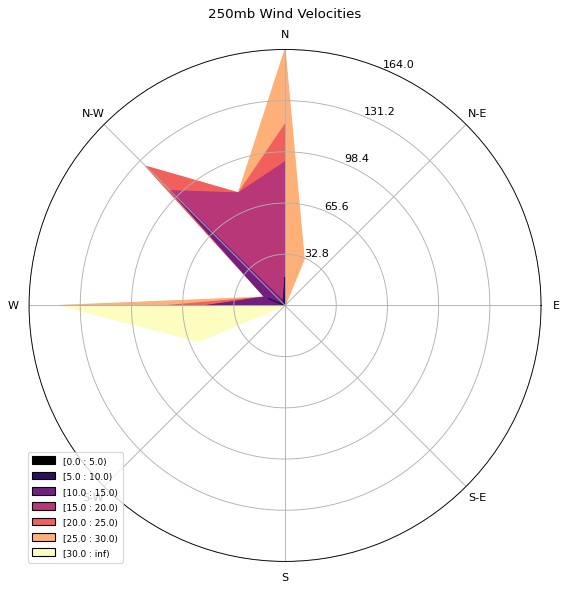

In [16]:
# Windplot for GFS data
df_main = pd.read_csv("csv/main_paper_gfs.csv")
df_main = df_main[['250_wspd', '250_wdir', "dataname"]].drop_duplicates()
#df_main["cft_avg_wspd"] = df_main["cft_avg_wspd"] * 0.5144447
#ws = df_main["cft_avg_wspd"].tolist()
#wd = df_main["cft_avg_wdir"].tolist()

df_main["250_wspd"] = df_main["250_wspd"] * 0.5144447
ws = df_main["250_wspd"].tolist()
wd = df_main["250_wdir"].tolist()

ax = WindroseAxes.from_ax()
ax.contourf(wd, ws, bins=np.arange(0, 35, 5), cmap=cm.magma)
ax.set_legend()
ax.set_title("250mb Wind Velocities")
plt.savefig('windplot_main_250_2.png',  dpi=300)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0747bd58d0>]],
      dtype=object)

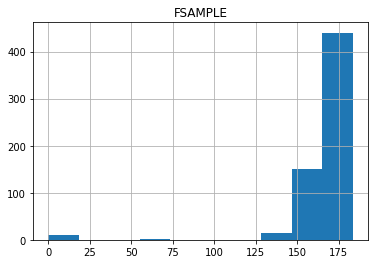

In [142]:
# Now running a loop on all date-time data 
# pull main data
df_main = pd.read_csv("csv/main_paper_gfs.csv")
df_main.sort_values('wfs', inplace=True)
df_main = df_main[['FSAMPLE', "dataname"]].drop_duplicates("dataname")

df_main
df_main.hist(column='FSAMPLE')

## Part 4: Pulling MASS DIMM data, add to table

This file was binned by Ryan Dungee and imported to ehu. 

Location:
```scp binned_massdimm.csv emcewen@ehu.ifa.hawaii.edu:/home/emcewen/data```

In [7]:
# pull main data
df_main = pd.read_csv("csv/main_paper.csv", index_col=0)
df_main["DATETIME"] = pd.to_datetime(df_main["DATETIME"])

# mass dimm file
df_md_p = "/home/emcewen/data/binned_massdimm.csv"

In [8]:
df_md = pd.read_csv(df_md_p)
df_md.index = pd.to_datetime(df_md["ISOFormat"])
df_md = df_md.groupby(level=0).first()
df_md.head()

,UTC-Date,UTC-Time,ISOFormat,DIMM,N_dimm,MASS,N_mass,Ground_Layer
ISOFormat,,,,,,,,
2018-05-30 14:24:19+00:00,2018-05-30,14:24:19,2018-05-30T14:24:19+00:00,0.920307,4,NaN,0,NaN
2018-05-30 14:29:19+00:00,2018-05-30,14:29:19,2018-05-30T14:29:19+00:00,0.825952,3,NaN,0,NaN
2018-05-30 14:34:19+00:00,2018-05-30,14:34:19,2018-05-30T14:34:19+00:00,0.670472,4,NaN,0,NaN
2018-05-30 14:39:19+00:00,2018-05-30,14:39:19,2018-05-30T14:39:19+00:00,0.733949,3,NaN,0,NaN
2018-05-30 14:44:19+00:00,2018-05-30,14:44:19,2018-05-30T14:44:19+00:00,0.905009,2,NaN,0,NaN


In [9]:
### Test Run
df_test = df_main.head()
df_md_p = "/home/emcewen/data/binned_massdimm.csv"
df_md_test = data_mass_dimm(df_test['DATETIME'].to_list(), df_md_p)
df_md_test

,md_datetime,md_date,md_time,DIMM,N_dimm,MASS,N_mass,ground_layer
0,2018-05-31 14:16:27+00:00,2018-05-31,14:16:27,0.624551,3,0.462650,4,0.356907
1,2018-05-31 14:16:27+00:00,2018-05-31,14:16:27,0.624551,3,0.462650,4,0.356907
2,2018-05-31 14:16:27+00:00,2018-05-31,14:16:27,0.624551,3,0.462650,4,0.356907
3,2018-05-31 14:16:27+00:00,2018-05-31,14:16:27,0.624551,3,0.462650,4,0.356907
4,2018-05-31 12:51:27+00:00,2018-05-31,12:51:27,0.750208,3,0.650034,3,0.296197


In [10]:
##################### THIS GENERATES MAIN_massdimm
#################### Expect it to take a few minutes
# pull main data
df_main = pd.read_csv("csv/main_paper.csv", index_col=0)
df_main["DATETIME"] = pd.to_datetime(df_main["DATETIME"])

#### WARNING: This function takes a lot of time ######
df_md_sort = data_mass_dimm(df_main['DATETIME'].to_list(), df_md_p)

# for each date, get two values back
df_main_massdimm = pd.concat([df_main, df_md_sort], axis=1, join="inner")

#store genereated csv file
df_main_massdimm.to_csv("csv/main_paper_massdimm.csv", index=False)

In [131]:
df_main_massdimm.head()

,dataname,OBSDATE,DATETIME,infits,outfits,outdir,targetfile,nwfs,tmax,ssub,...,runfile,run,md_datetime,md_date,md_time,DIMM,N_dimm,MASS,N_mass,ground_layer
0,20180531_aocb0077o,20180531,2018-05-31 14:18:22,/home/imaka/data/20180531/ao/aocb0077o.fits,/home/emcewen/out/20180531/fits/20180531_aocb0...,/home/emcewen/out/20180531/,FLD2,4,200,True,...,/home/emcewen/imaka_wfp/inputs/runs/RUN_paper.txt,_paper,2018-05-31 14:16:27+00:00,2018-05-31,14:16:27,0.624551,3,0.462650,4,0.356907
1,20180531_aocb0077o,20180531,2018-05-31 14:18:22,/home/imaka/data/20180531/ao/aocb0077o.fits,/home/emcewen/out/20180531/fits/20180531_aocb0...,/home/emcewen/out/20180531/,FLD2,4,200,True,...,/home/emcewen/imaka_wfp/inputs/runs/RUN_paper.txt,_paper,2018-05-31 14:16:27+00:00,2018-05-31,14:16:27,0.624551,3,0.462650,4,0.356907
2,20180531_aocb0077o,20180531,2018-05-31 14:18:22,/home/imaka/data/20180531/ao/aocb0077o.fits,/home/emcewen/out/20180531/fits/20180531_aocb0...,/home/emcewen/out/20180531/,FLD2,4,200,True,...,/home/emcewen/imaka_wfp/inputs/runs/RUN_paper.txt,_paper,2018-05-31 14:16:27+00:00,2018-05-31,14:16:27,0.624551,3,0.462650,4,0.356907
3,20180531_aocb0077o,20180531,2018-05-31 14:18:22,/home/imaka/data/20180531/ao/aocb0077o.fits,/home/emcewen/out/20180531/fits/20180531_aocb0...,/home/emcewen/out/20180531/,FLD2,4,200,True,...,/home/emcewen/imaka_wfp/inputs/runs/RUN_paper.txt,_paper,2018-05-31 14:16:27+00:00,2018-05-31,14:16:27,0.624551,3,0.462650,4,0.356907
4,20180531_aocb0017o,20180531,2018-05-31 12:50:32,/home/imaka/data/20180531/ao/aocb0017o.fits,/home/emcewen/out/20180531/fits/20180531_aocb0...,/home/emcewen/out/20180531/,FLD2,4,200,False,...,/home/emcewen/imaka_wfp/inputs/runs/RUN_paper.txt,_paper,2018-05-31 12:51:27+00:00,2018-05-31,12:51:27,0.750208,3,0.650034,3,0.296197


In [11]:
# drop NAN or +30 min DIMM
df_md_test = df_main_massdimm[['DATETIME','DIMM', 'MASS', "dataname", "ground_layer"]].drop_duplicates()
df_md_test.dropna()
df_md_test = df_md_test.sort_values('dataname').reset_index()


In [17]:
df_main_massdimm

,dataname,OBSDATE,DATETIME,infits,outfits,outdir,targetfile,nwfs,tmax,ssub,...,runfile,run,md_datetime,md_date,md_time,DIMM,N_dimm,MASS,N_mass,ground_layer
0,20180531_aocb0077o,20180531,2018-05-31 14:18:22,/home/imaka/data/20180531/ao/aocb0077o.fits,/home/emcewen/out/20180531/fits/20180531_aocb0...,/home/emcewen/out/20180531/,FLD2,4,200,True,...,/home/emcewen/imaka_wfp/inputs/runs/RUN_paper.txt,_paper,2018-05-31 14:16:27+00:00,2018-05-31,14:16:27,0.624551,3,0.462650,4,0.356907
1,20180531_aocb0077o,20180531,2018-05-31 14:18:22,/home/imaka/data/20180531/ao/aocb0077o.fits,/home/emcewen/out/20180531/fits/20180531_aocb0...,/home/emcewen/out/20180531/,FLD2,4,200,True,...,/home/emcewen/imaka_wfp/inputs/runs/RUN_paper.txt,_paper,2018-05-31 14:16:27+00:00,2018-05-31,14:16:27,0.624551,3,0.462650,4,0.356907
2,20180531_aocb0077o,20180531,2018-05-31 14:18:22,/home/imaka/data/20180531/ao/aocb0077o.fits,/home/emcewen/out/20180531/fits/20180531_aocb0...,/home/emcewen/out/20180531/,FLD2,4,200,True,...,/home/emcewen/imaka_wfp/inputs/runs/RUN_paper.txt,_paper,2018-05-31 14:16:27+00:00,2018-05-31,14:16:27,0.624551,3,0.462650,4,0.356907
3,20180531_aocb0077o,20180531,2018-05-31 14:18:22,/home/imaka/data/20180531/ao/aocb0077o.fits,/home/emcewen/out/20180531/fits/20180531_aocb0...,/home/emcewen/out/20180531/,FLD2,4,200,True,...,/home/emcewen/imaka_wfp/inputs/runs/RUN_paper.txt,_paper,2018-05-31 14:16:27+00:00,2018-05-31,14:16:27,0.624551,3,0.462650,4,0.356907
4,20180531_aocb0017o,20180531,2018-05-31 12:50:32,/home/imaka/data/20180531/ao/aocb0017o.fits,/home/emcewen/out/20180531/fits/20180531_aocb0...,/home/emcewen/out/20180531/,FLD2,4,200,False,...,/home/emcewen/imaka_wfp/inputs/runs/RUN_paper.txt,_paper,2018-05-31 12:51:27+00:00,2018-05-31,12:51:27,0.750208,3,0.650034,3,0.296197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11979,20181223_aocb0416o,20181223,2018-12-23 13:22:44,/home/imaka/data/20181223/ao/aocb0416o.fits,/home/emcewen/out/20181223/fits/20181223_aocb0...,/home/emcewen/out/20181223/,NaN,5,1000,True,...,/home/emcewen/imaka_wfp/inputs/runs/RUN_paper.txt,_paper,2018-12-23 13:21:11+00:00,2018-12-23,13:21:11,0.759185,3,0.913788,4,NaN
11980,20181223_aocb0416o,20181223,2018-12-23 13:22:44,/home/imaka/data/20181223/ao/aocb0416o.fits,/home/emcewen/out/20181223/fits/20181223_aocb0...,/home/emcewen/out/20181223/,NaN,5,1000,True,...,/home/emcewen/imaka_wfp/inputs/runs/RUN_paper.txt,_paper,2018-12-23 13:21:11+00:00,2018-12-23,13:21:11,0.759185,3,0.913788,4,NaN
11981,20181223_aocb0416o,20181223,2018-12-23 13:22:44,/home/imaka/data/20181223/ao/aocb0416o.fits,/home/emcewen/out/20181223/fits/20181223_aocb0...,/home/emcewen/out/20181223/,NaN,5,1000,True,...,/home/emcewen/imaka_wfp/inputs/runs/RUN_paper.txt,_paper,2018-12-23 13:21:11+00:00,2018-12-23,13:21:11,0.759185,3,0.913788,4,NaN
11982,20181223_aocb0416o,20181223,2018-12-23 13:22:44,/home/imaka/data/20181223/ao/aocb0416o.fits,/home/emcewen/out/20181223/fits/20181223_aocb0...,/home/emcewen/out/20181223/,NaN,5,1000,True,...,/home/emcewen/imaka_wfp/inputs/runs/RUN_paper.txt,_paper,2018-12-23 13:21:11+00:00,2018-12-23,13:21:11,0.759185,3,0.913788,4,NaN


In [13]:

df_dates = df_md_test["DATETIME"].map(lambda t: t.date()).unique()
count_arr = [df_md_test['DATETIME'].map(lambda t: t.date()).value_counts()[i] for i in df_dates]

count_arr = np.roll(np.cumsum(count_arr), 1)
count_arr[0] = 0
count_arr

array([  0,  25,  94, 204, 301, 381, 525, 549, 567, 582])

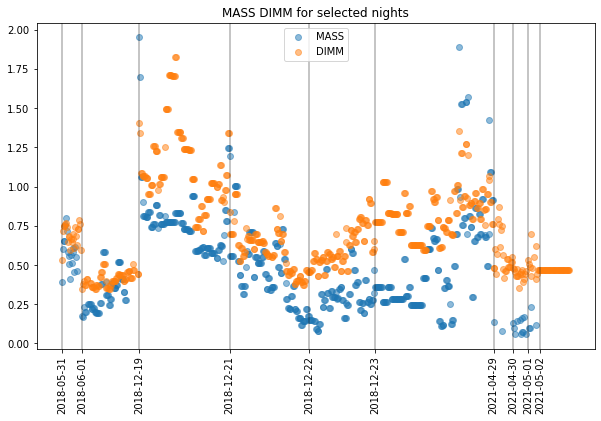

In [14]:
fig = plt.figure(figsize=(10,6))
plt.xticks([], [])
plt.scatter(df_md_test["dataname"], df_md_test["MASS"], alpha=0.5, label="MASS")
plt.scatter(df_md_test["dataname"], df_md_test["DIMM"], alpha=0.5, label="DIMM")

for c in count_arr:
    plt.axvline(c, c="black", alpha = 0.3)
plt.xticks(count_arr, df_dates, rotation ='vertical') 

plt.legend()
plt.title("MASS DIMM for selected nights")
plt.show()

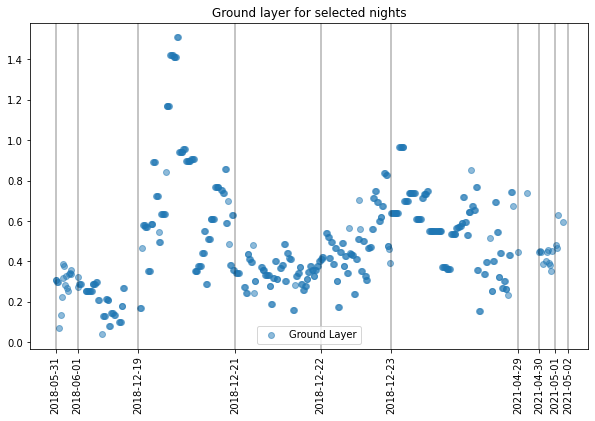

In [16]:
fig = plt.figure(figsize=(10,6))
plt.xticks([], [])
plt.scatter(df_md_test["dataname"], df_md_test["ground_layer"], alpha=0.5, label="Ground Layer")

for c in count_arr:
    plt.axvline(c, c="black", alpha = 0.3)
plt.xticks(count_arr, df_dates, rotation ='vertical') 

plt.legend()
plt.title("Ground layer for selected nights")
plt.show()

# Section 2:  Corellation Analysis

## S2 Part 1: Extracting Velocities

In [22]:
reload(er)

<module 'pipeline.code.Estimator_R' from '/home/emcewen/code_dev/pipeline/code/Estimator_R.py'>

In [17]:
# pulling in dates
df_main = pd.read_csv("/home/emcewen/code_dev/csv/main_paper.csv")
# filtering type of file
rslt_df = df_main[df_main['ttsub'] == True]
rslt_df = rslt_df.drop_duplicates(subset=['dataname'])
# pulling cov fits files
fits = rslt_df["outfits"]
#input fits
fits_main_in = fits.values

In [21]:
for i in fits_main_in:
    er.est_file(i, plot = True)

/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0049o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0014o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0085o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0057o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0022o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0092o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0093o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0045o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0026o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0037o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0033o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0053o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0081o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0069o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0089o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0019o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0082o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0077o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0008o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0073o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0041o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0065o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0017o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0029o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180531/est/cor_prob/20180531_aocb0061o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0066o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0110o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0116o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0106o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0074o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0082o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0128o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0090o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0122o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0092o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0124o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0006o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0078o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0020o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0016o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0102o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0052o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0060o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0132o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0138o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0070o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0064o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0038o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0104o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0026o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0032o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0062o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0094o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0108o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0040o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0010o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0098o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0056o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0034o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0014o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0072o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0058o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0024o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0001o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0114o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0088o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0086o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0134o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0042o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0012o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0112o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0044o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0126o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0048o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0084o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0096o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0008o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0028o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0068o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0118o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0004o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0136o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0022o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0054o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0030o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0050o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0120o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0100o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0130o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0036o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0076o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0046o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0018o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20180601/est/cor_prob/20180601_aocb0080o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0005o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0049o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0009o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0021o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0023o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0019o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0047o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0013o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0039o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0033o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0035o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0043o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0025o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0031o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0027o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0037o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0041o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0002o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0011o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0015o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0017o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0029o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0006o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/est/cor_prob/20210429_aocb0045o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210430/est/cor_prob/20210430_aocb0017o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210430/est/cor_prob/20210430_aocb0029o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210430/est/cor_prob/20210430_aocb0046o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210430/est/cor_prob/20210430_aocb0019o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210430/est/cor_prob/20210430_aocb0007o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210430/est/cor_prob/20210430_aocb0011o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210430/est/cor_prob/20210430_aocb0031o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210430/est/cor_prob/20210430_aocb0015o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210430/est/cor_prob/20210430_aocb0023o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210430/est/cor_prob/20210430_aocb0025o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210430/est/cor_prob/20210430_aocb0048o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210430/est/cor_prob/20210430_aocb0013o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210430/est/cor_prob/20210430_aocb0001o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210430/est/cor_prob/20210430_aocb0009o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210430/est/cor_prob/20210430_aocb0003o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210430/est/cor_prob/20210430_aocb0005o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210430/est/cor_prob/20210430_aocb0027o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210430/est/cor_prob/20210430_aocb0021o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210501/est/cor_prob/20210501_aocb0003o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210501/est/cor_prob/20210501_aocb0033o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210501/est/cor_prob/20210501_aocb0020o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210501/est/cor_prob/20210501_aocb0018o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210501/est/cor_prob/20210501_aocb0014o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210501/est/cor_prob/20210501_aocb0039o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210501/est/cor_prob/20210501_aocb0009o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210501/est/cor_prob/20210501_aocb0025o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210501/est/cor_prob/20210501_aocb0023o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210501/est/cor_prob/20210501_aocb0030o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210501/est/cor_prob/20210501_aocb0001o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210501/est/cor_prob/20210501_aocb0007o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210501/est/cor_prob/20210501_aocb0035o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210501/est/cor_prob/20210501_aocb0012o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210501/est/cor_prob/20210501_aocb0028o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0078o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0018o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0043o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0061o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0019o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0012o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0083o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0009o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0073o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0071o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0095o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0011o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0010o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0093o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0008o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0045o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0056o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0088o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0035o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0046o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0066o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0063o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0022o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0044o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0021o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0086o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0047o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0036o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0068o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0020o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0081o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0054o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0033o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0034o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0076o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210502/est/cor_prob/20210502_aocb0037o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0176o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0316o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0119o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0190o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0104o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0105o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0086o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0121o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0323o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0120o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0135o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0167o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0159o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0168o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0093o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0144o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0081o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0146o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0248o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0224o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0161o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0128o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0278o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0113o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0100o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0328o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0170o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0092o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0178o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0225o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0189o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0266o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0329o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0137o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0292o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0247o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0305o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0226o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0114o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0339o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0175o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0069o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0082o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0075o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0293o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0322o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0049o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0188o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0311o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0244o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0280o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0143o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0076o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0127o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0074o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0111o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0138o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0043o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0122o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0152o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0154o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0281o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0151o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0153o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0338o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0062o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0298o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0162o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0160o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0317o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0287o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0277o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20181219/est/cor_prob/20181219_aocb0177o_stt_cor_prob_0.png


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

ValueError: No point was within bandwidth=0.000000 of any seed. Try a different seeding strategy                              or increase the bandwidth.

### Extracting by a specific date:

In [26]:
## List of fits files per date:
idate = 20210429
# filtering type of file
rslt_df = df_main[df_main['OBSDATE'] == idate]
# pulling cov fits files
fits = rslt_df["outfits"]
#input fits
fits_in = fits.values

In [29]:
df_i_ms = pd.DataFrame()
#method = er.detect_cluster_meanshift

for fts in fits_in:
    print(fts)
    er_pipe = er.Estimate_simple(fts)
    table = er_pipe.return_table(sdv_cnd = 2, n_filter = 20)
    df_i_ms = pd.concat([df_i_ms, table])
df_i_ms["method"] = "meanshift"

/home/emcewen/out/20210429/fits/20210429_aocb0005o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0005o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0005o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0005o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0005o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0011o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0011o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0011o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0011o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0011o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0039o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0039o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0039o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0039o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0039o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0049o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0049o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0049o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0049o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0049o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0049o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0049o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0049o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0049o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0049o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0019o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0019o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0019o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0019o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0019o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0009o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0009o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0009o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0009o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0009o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0025o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0025o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0025o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0025o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0025o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0021o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0021o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0021o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0021o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0021o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0033o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0033o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0033o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0033o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0033o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0023o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0023o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0023o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0023o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0023o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0017o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0017o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0017o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0017o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0017o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0005o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0005o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0005o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0005o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0005o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0023o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0023o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0023o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0023o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0023o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0031o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0031o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0031o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0031o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0031o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0049o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0049o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0049o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0049o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0049o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0002o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0002o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0002o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0002o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0002o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0019o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0019o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0019o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0019o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0019o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0047o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0047o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0047o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0047o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0047o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0015o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0015o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0015o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0015o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0015o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0023o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0023o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0023o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0023o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0023o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0015o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0015o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0015o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0015o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0015o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0045o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0045o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0045o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0045o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0045o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0047o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0047o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0047o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0047o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0047o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0025o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0025o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0025o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0025o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0025o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0035o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0035o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0035o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0035o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0035o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0039o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0039o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0039o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0039o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0039o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0041o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0041o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0041o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0041o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0041o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0033o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0033o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0033o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0033o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0033o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0045o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0045o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0045o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0045o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0045o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0021o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0021o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0021o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0021o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0021o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0027o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0027o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0027o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0027o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0027o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0035o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0035o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0035o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0035o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0035o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0043o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0043o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0043o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0043o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0043o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0025o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0025o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0025o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0025o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0025o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0031o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0031o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0031o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0031o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0031o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0043o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0043o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0043o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0043o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0043o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0041o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0041o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0041o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0041o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0041o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0027o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0027o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0027o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0027o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0027o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0002o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0002o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0002o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0002o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0002o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0011o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0011o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0011o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0011o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0011o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0037o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0037o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0037o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0037o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0037o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0041o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0041o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0041o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0041o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0041o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0033o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0033o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0033o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0033o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0033o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0009o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0009o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0009o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0009o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0009o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0037o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0037o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0037o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0037o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0037o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0006o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0006o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0006o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0006o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0006o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0047o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0047o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0047o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0047o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0047o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0002o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0002o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0002o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0002o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0002o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0011o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0011o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0011o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0011o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0011o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0035o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0035o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0035o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0035o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0035o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0015o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0015o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0015o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0015o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0015o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0019o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0019o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0019o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0019o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0019o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0029o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0029o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0029o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0029o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0029o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0037o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0037o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0037o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0037o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0037o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0017o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0017o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0017o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0017o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0017o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0027o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0027o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0027o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0027o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0027o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0029o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0029o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0029o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0029o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0029o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0005o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0005o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0005o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0005o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0005o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0017o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0017o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0017o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0017o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0017o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0006o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0006o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0006o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0006o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0006o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0009o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0009o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0009o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0009o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0009o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0043o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0043o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0043o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0043o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0043o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0029o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0029o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0029o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0029o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0029o_tmax200_raw.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0021o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0021o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0021o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0021o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0021o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0006o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0006o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0006o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0006o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0006o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0031o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0031o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0031o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0031o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0031o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0045o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0045o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0045o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0045o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0045o_tmax200_stt.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0039o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0039o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0039o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0039o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0039o_tmax200_s.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0011o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0011o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0011o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0011o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0011o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0006o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0006o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0006o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0006o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0006o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0015o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0015o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0015o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0015o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0015o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0005o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0005o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0005o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0005o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0005o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0017o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0017o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0017o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0017o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0017o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0009o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0009o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0009o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0009o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0009o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0019o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0019o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0019o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0019o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0019o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0021o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0021o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0021o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0021o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0021o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0043o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0043o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0043o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0043o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0043o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0047o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0047o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0047o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0047o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0047o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0049o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0049o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0049o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0049o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0049o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0023o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0023o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0023o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0023o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0023o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0031o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0031o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0031o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0031o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0031o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0033o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0033o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0033o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0033o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0033o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0025o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0025o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0025o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0025o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0025o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0035o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0035o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0035o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0035o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0035o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0037o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0037o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0037o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0037o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0037o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0041o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0041o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0041o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0041o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0041o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0027o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0027o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0027o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0027o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0027o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0029o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0029o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0029o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0029o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0029o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0045o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0045o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0045o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0045o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0045o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0039o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0039o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0039o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)


/home/emcewen/out/20210429/fits/20210429_aocb0039o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0039o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0002o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0002o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0002o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0002o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

/home/emcewen/out/20210429/fits/20210429_aocb0002o_tmax1000_tts.fits


/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  detect_t = ma.masked_where(t_slice <= detect_val, t_slice)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: divide by zero encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:705: RuntimeWarning: invalid value encountered in true_divide
  detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
/home/emcewen/code_dev/pipeline/code/Estimator_R.py:776: RuntimeWarning: invalid value encountered in less_equal
  d

<bound method Figure.show of <Figure size 720x360 with 1 Axes>>

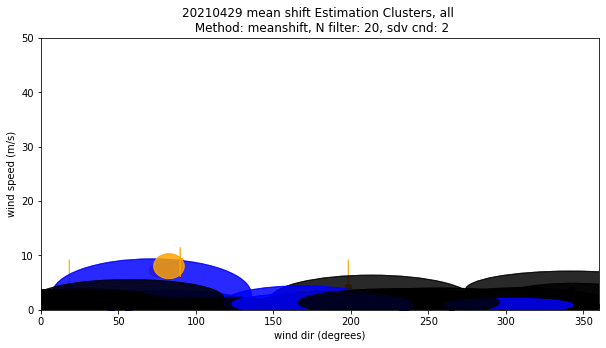

In [30]:
date_name = f"{idate} mean shift"
er.plot_clstr_table(df_i_ms[df_i_ms["dir_std"] < 50 ], min_count=0, name=date_name).show